In [6]:
#Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense,BatchNormalization,Dropout,LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score,recall_score,confusion_matrix,classification_report ,accuracy_score,f1_score
from  keras import callbacks

In [ ]:
np.random.seed(0)
dt= pd.read_csv('/content/weatherAUS.csv')
dt

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,0.0,No
142189,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,0.0,No
142190,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,0.0,No
142191,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,0.0,No


In [ ]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [ ]:
dt.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

<Axes: xlabel='RainTomorrow', ylabel='count'>

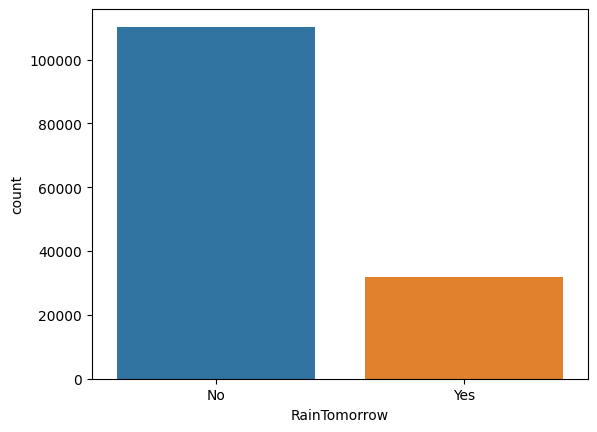

In [ ]:
#Evaluating the target values
sns.countplot(x=dt['RainTomorrow'])

In [ ]:
dt.shape

(142193, 24)

In [ ]:
#There don't seem to be any error in dates so parsing values into datetime
dt['Date']= pd.to_datetime(dt["Date"])
#Creating a collumn of year
dt['year'] = dt.Date.dt.year
def encode(dt, col, max_val):
    dt[col + '_sin'] = np.sin(2 * np.pi * dt[col]/max_val)
    dt[col + '_cos'] = np.cos(2 * np.pi * dt[col]/max_val)
    return dt
dt['month'] = dt.Date.dt.month
dt = encode(dt, 'month', 12)
dt['day'] = dt.Date.dt.day
dt = encode(dt, 'day', 31)
dt.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,RainToday,RISK_MM,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,No,0.0,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,No,0.0,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,No,0.0,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,No,1.0,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,No,0.2,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


In [ ]:
Categorical_variables=(dt.dtypes=='object')
object_cols = list(Categorical_variables[Categorical_variables].index)
print("Categorical variables:",object_cols)

Categorical variables: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [ ]:
# Missing values in categorical variables
for i in object_cols:
    print(i, dt[i].isnull().sum())


Location 0
WindGustDir 9330
WindDir9am 10013
WindDir3pm 3778
RainToday 1406
RainTomorrow 0


In [ ]:
# Filling missing values with mode of the column in valu
for i in object_cols:
    dt[i].fillna(dt[i].mode()[0], inplace=True)
# Get list of neumeric variables
t = (dt.dtypes == "float64")
num_cols = list(t[t].index)
print("Numeric variables:")
print(num_cols)


Numeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RISK_MM', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [ ]:
# Missing values in numeric variables
for i in num_cols:
    print(i, dt[i].isnull().sum())

MinTemp 637
MaxTemp 322
Rainfall 1406
Evaporation 60843
Sunshine 67816
WindGustSpeed 9270
WindSpeed9am 1348
WindSpeed3pm 2630
Humidity9am 1774
Humidity3pm 3610
Pressure9am 14014
Pressure3pm 13981
Cloud9am 53657
Cloud3pm 57094
Temp9am 904
Temp3pm 2726
RISK_MM 0
month_sin 0
month_cos 0
day_sin 0
day_cos 0


<Axes: >

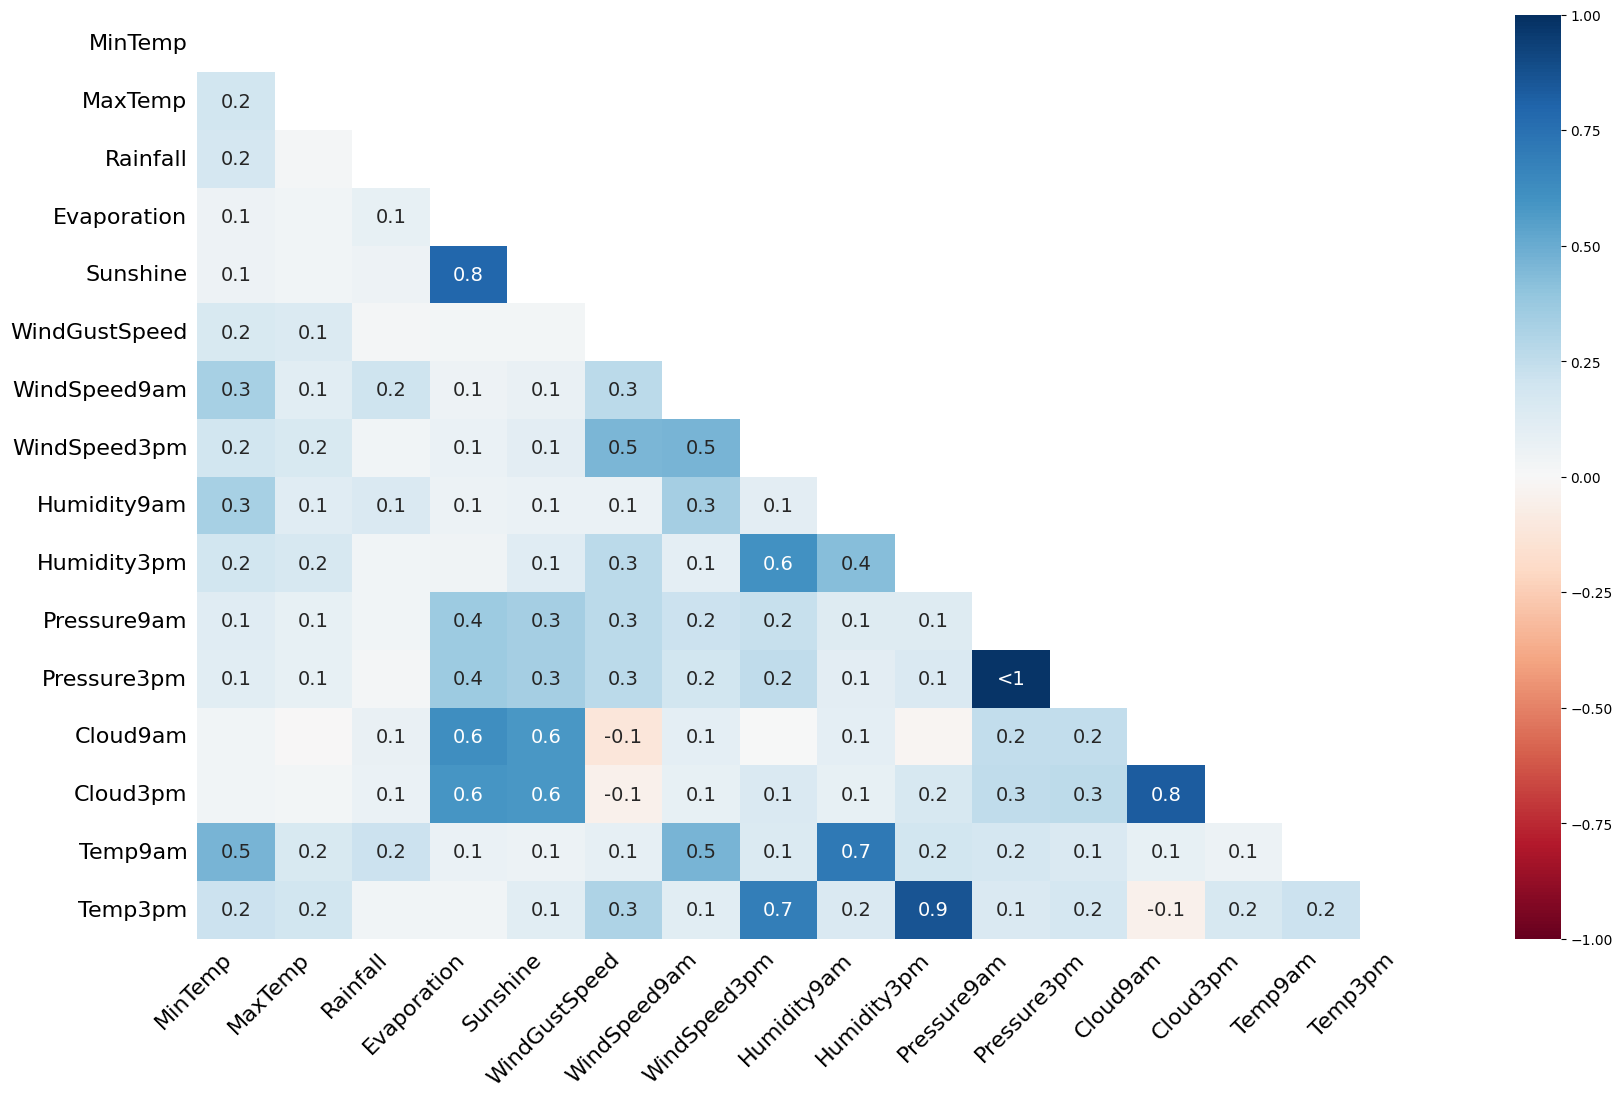

In [ ]:
import missingno as msno
msno.heatmap(dt)

<Axes: >

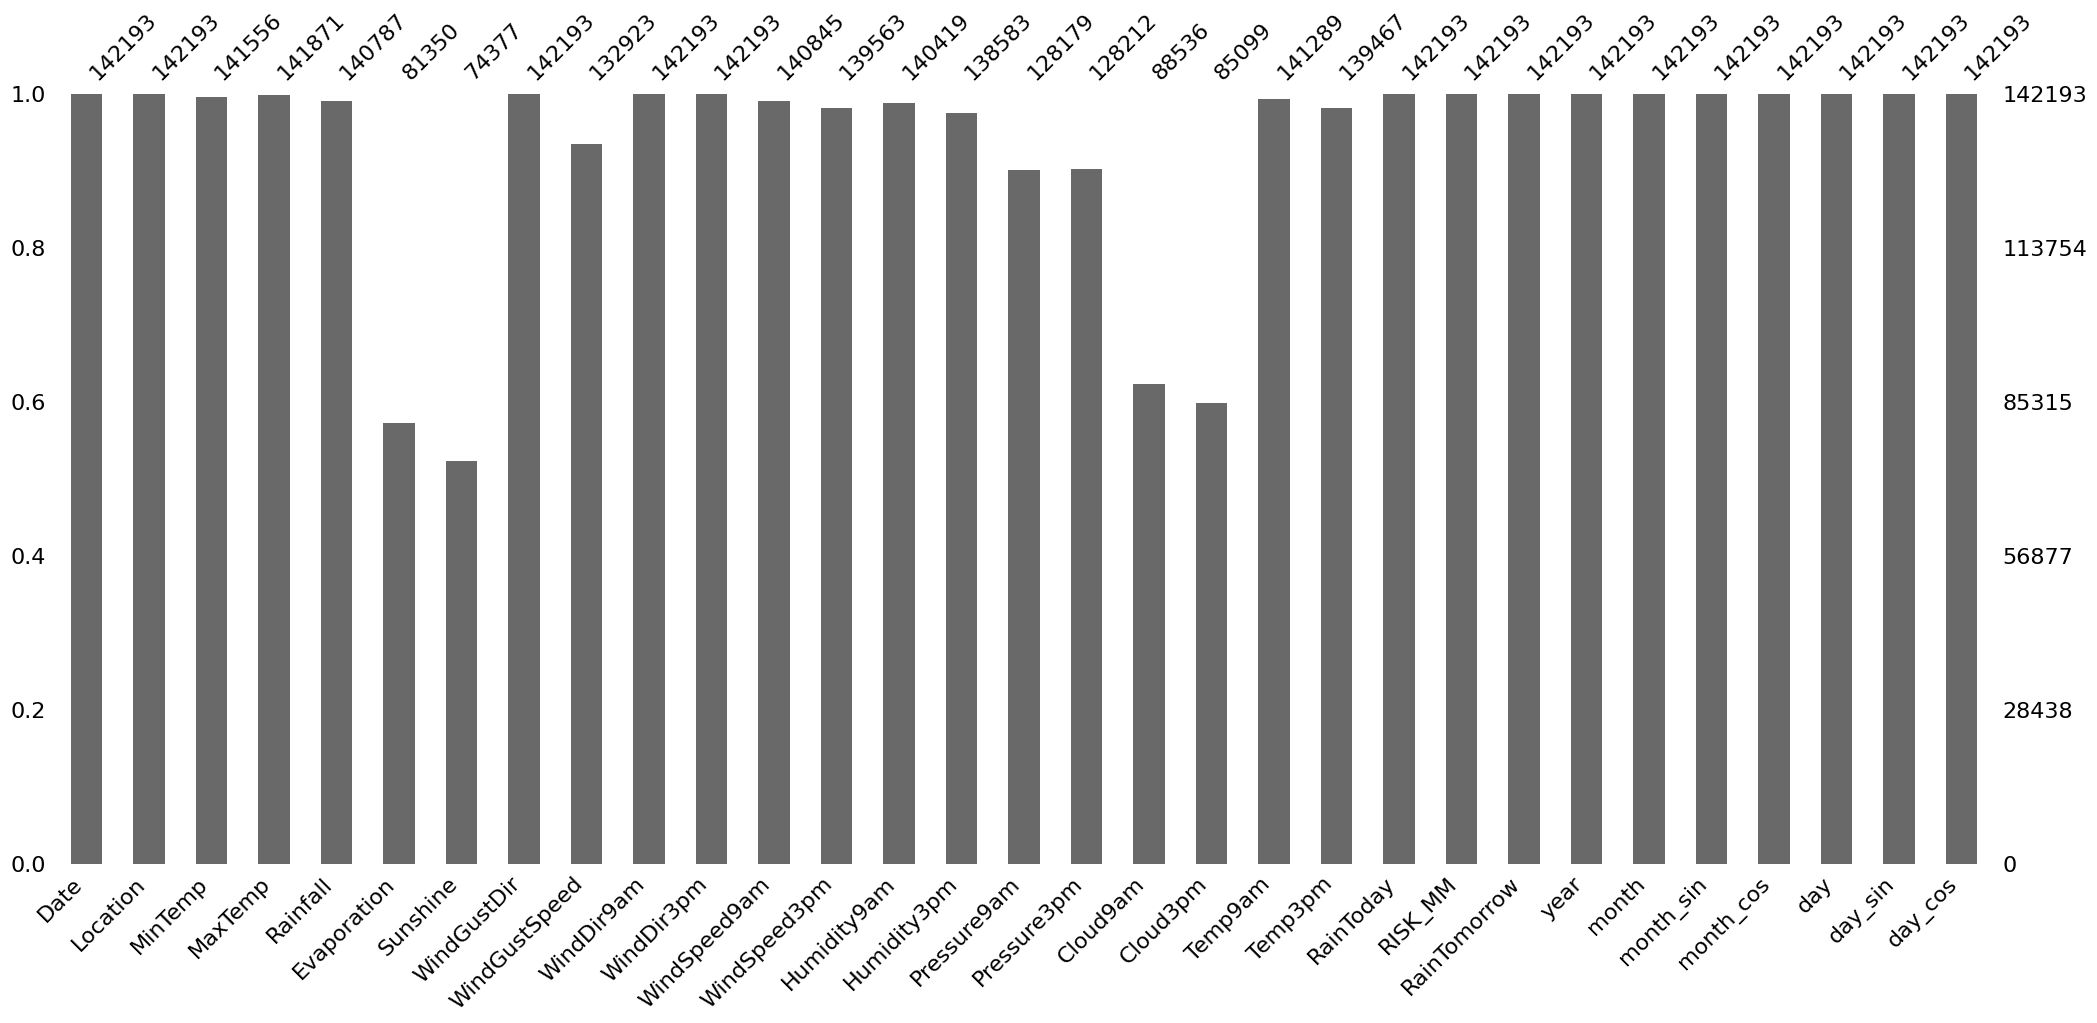

In [ ]:
msno.bar(dt)

<Axes: >

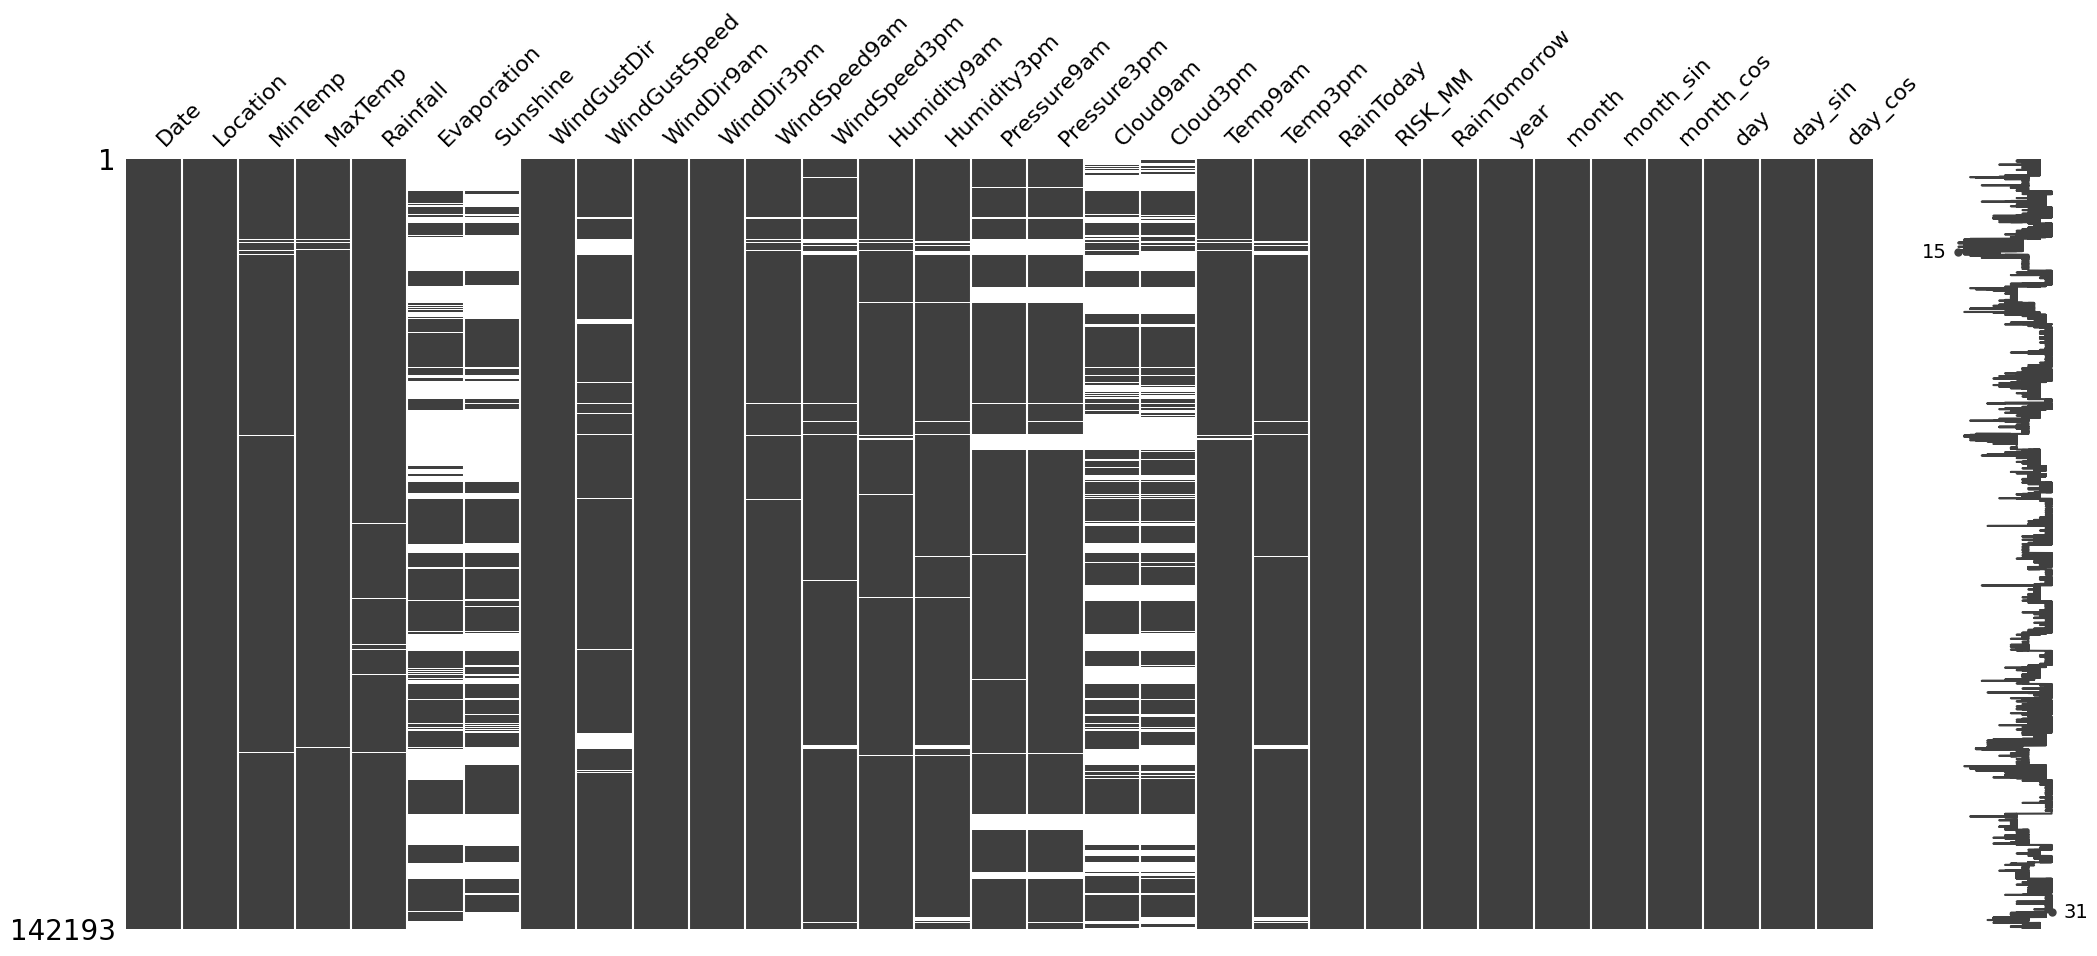

In [ ]:
msno.matrix(dt)

In [ ]:
# Filling missing values with median of the column in value
for i in num_cols:
    dt[i].fillna(dt[i].median(), inplace=True)
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           142193 non-null  datetime64[ns]
 1   Location       142193 non-null  object        
 2   MinTemp        142193 non-null  float64       
 3   MaxTemp        142193 non-null  float64       
 4   Rainfall       142193 non-null  float64       
 5   Evaporation    142193 non-null  float64       
 6   Sunshine       142193 non-null  float64       
 7   WindGustDir    142193 non-null  object        
 8   WindGustSpeed  142193 non-null  float64       
 9   WindDir9am     142193 non-null  object        
 10  WindDir3pm     142193 non-null  object        
 11  WindSpeed9am   142193 non-null  float64       
 12  WindSpeed3pm   142193 non-null  float64       
 13  Humidity9am    142193 non-null  float64       
 14  Humidity3pm    142193 non-null  float64       
 15  

1. Perform the necessary pre-processing.


In [ ]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    dt[i] = label_encoder.fit_transform(dt[i])
dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           142193 non-null  datetime64[ns]
 1   Location       142193 non-null  int64         
 2   MinTemp        142193 non-null  float64       
 3   MaxTemp        142193 non-null  float64       
 4   Rainfall       142193 non-null  float64       
 5   Evaporation    142193 non-null  float64       
 6   Sunshine       142193 non-null  float64       
 7   WindGustDir    142193 non-null  int64         
 8   WindGustSpeed  142193 non-null  float64       
 9   WindDir9am     142193 non-null  int64         
 10  WindDir3pm     142193 non-null  int64         
 11  WindSpeed9am   142193 non-null  float64       
 12  WindSpeed3pm   142193 non-null  float64       
 13  Humidity9am    142193 non-null  float64       
 14  Humidity3pm    142193 non-null  float64       
 15  

In [ ]:
# Prepairing attributes of scale data
features = dt.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) #dropping target and extra columns
target = dt['RainTomorrow']
#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)
features.describe().T


,count,mean,std,min,25%,50%,75%,max
Location,142193.0,2.398575e-17,1.000004,-1.667479,-0.894869,0.018216,0.861063,1.703910
MinTemp,142193.0,3.166118e-16,1.000004,-3.237728,-0.717738,-0.029045,0.722257,3.398768
MaxTemp,142193.0,3.421966e-16,1.000004,-3.941909,-0.749039,-0.087961,0.699708,3.498743
Rainfall,142193.0,8.594892e-17,1.000004,-0.276125,-0.276125,-0.276125,-0.204920,43.752188
Evaporation,142193.0,-1.071363e-16,1.000004,-1.627183,-0.371450,-0.120303,0.068057,43.893144
Sunshine,142193.0,7.259686e-16,1.000004,-2.903725,0.056962,0.165280,0.237492,2.331636
WindGustDir,142193.0,-1.471126e-16,1.000004,-1.716789,-0.864683,0.200450,1.052556,1.478609
WindGustSpeed,142193.0,1.778943e-16,1.000004,-2.581325,-0.678822,-0.070021,0.462679,7.235589
WindDir9am,142193.0,-5.756579e-17,1.000004,-1.550574,-0.886072,-0.000070,0.885932,1.771934
WindDir3pm,142193.0,3.837719e-17,1.000004,-1.713146,-0.833311,0.046525,0.926360,1.586236


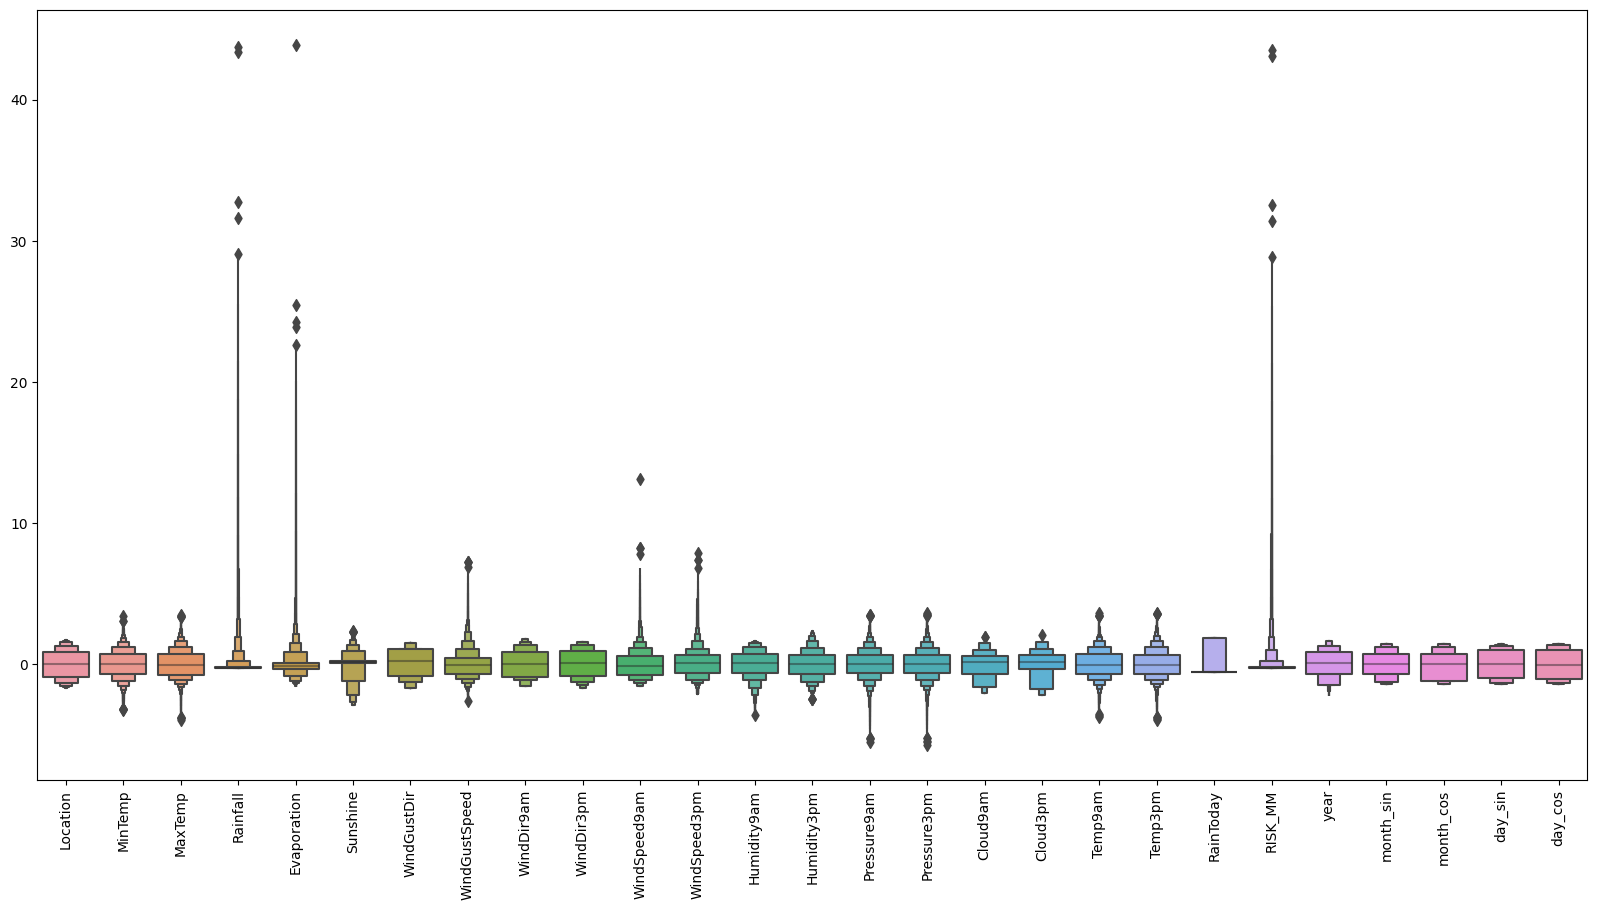

In [ ]:
#Detecting outliers
#looking at the scaled features
plt.figure(figsize=(20,10))
sns.boxenplot(data = features )
plt.xticks(rotation=90)
plt.show()


In [ ]:
#full data for
features["RainTomorrow"] = target
#Dropping with outlier
features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features=features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]<
2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]<
2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]
features.shape


(124759, 28)

2. Build an ANN model. Plot accuracy and loss for training and validation dataset

In [ ]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]
# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 42)
X.shape

(124759, 27)

In [ ]:
y.shape

(124759,)

2. Build an ANN model. Plot accuracy and loss for training and validation dataset.

In [ ]:
# Initialising the NN
model = Sequential()
# Add input layer and first hidden layer
model.add(Dense(16, activation='relu', input_dim=27))
# Add second hidden layer
model.add(Dense(16, activation='relu'))
# Add output layer
model.add(Dense(1, activation='sigmoid'))




In [ ]:
# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics =
['accuracy'])

In [ ]:
import tensorflow as tf
early_stopping=tf.keras.callbacks.EarlyStopping()

In [ ]:
# Train the ANN

history = model.fit(X_train, y_train, batch_size = 32, epochs = 50,
 validation_split=0.2)



Epoch 1/50
2496/2496 [==============================] - 10s 4ms/step - loss: 0.4614 - accuracy: 0.7891 - val_loss: 0.3512 - val_accuracy: 0.8528
Epoch 2/50
2496/2496 [==============================] - 10s 4ms/step - loss: 0.3160 - accuracy: 0.8701 - val_loss: 0.2757 - val_accuracy: 0.8890
Epoch 3/50
2496/2496 [==============================] - 9s 4ms/step - loss: 0.2530 - accuracy: 0.8995 - val_loss: 0.2213 - val_accuracy: 0.9142
Epoch 4/50
2496/2496 [==============================] - 10s 4ms/step - loss: 0.2006 - accuracy: 0.9224 - val_loss: 0.1729 - val_accuracy: 0.9339
Epoch 5/50
2496/2496 [==============================] - 9s 4ms/step - loss: 0.1537 - accuracy: 0.9419 - val_loss: 0.1298 - val_accuracy: 0.9509
Epoch 6/50
2496/2496 [==============================] - 9s 4ms/step - loss: 0.1140 - accuracy: 0.9572 - val_loss: 0.0946 - val_accuracy: 0.9637
Epoch 7/50
2496/2496 [==============================] - 9s 4ms/step - loss: 0.0835 - accuracy: 0.9686 - val_loss: 0.0694 - val_accura

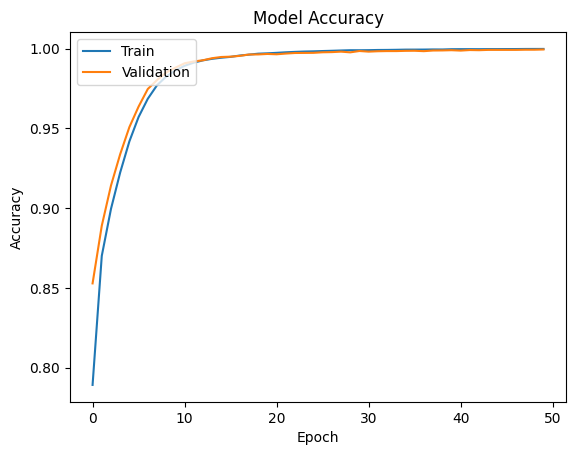

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



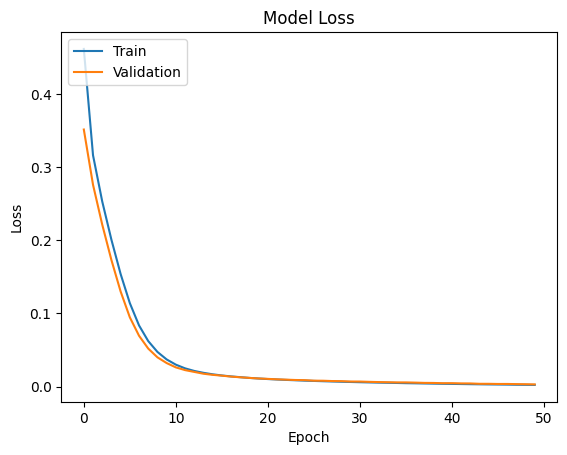

In [ ]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

3. Implement two regularization techniques and analyze the performance before and after
regularization

In [ ]:
# Add L1 regularization
model1=Sequential()
from keras.regularizers import l1,l2
model1.add(Dense(16, activation='relu', input_dim=27,
kernel_regularizer=l1(0.001)))
# Add L2 regularization
model1.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))

In [ ]:
# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model1.compile(optimizer = opt, loss = 'binary_crossentropy', metrics =
['accuracy'])

In [ ]:
# Train the model with regularization
history_reg = model1.fit(X_train, y_train, batch_size = 32, epochs = 50,
 validation_split=0.2)


Epoch 1/50
2496/2496 [==============================] - 10s 4ms/step - loss: 2.3144 - accuracy: 0.2606 - val_loss: 2.1179 - val_accuracy: 0.2467
Epoch 2/50
2496/2496 [==============================] - 9s 4ms/step - loss: 2.0215 - accuracy: 0.2202 - val_loss: 1.8860 - val_accuracy: 0.2042
Epoch 3/50
2496/2496 [==============================] - 9s 4ms/step - loss: 1.8001 - accuracy: 0.1875 - val_loss: 1.6848 - val_accuracy: 0.1718
Epoch 4/50
2496/2496 [==============================] - 12s 5ms/step - loss: 1.6086 - accuracy: 0.1543 - val_loss: 1.5032 - val_accuracy: 0.1470
Epoch 5/50
2496/2496 [==============================] - 9s 4ms/step - loss: 1.4291 - accuracy: 0.1415 - val_loss: 1.3209 - val_accuracy: 0.1288
Epoch 6/50
2496/2496 [==============================] - 10s 4ms/step - loss: 1.2504 - accuracy: 0.1086 - val_loss: 1.1495 - val_accuracy: 0.0917
Epoch 7/50
2496/2496 [==============================] - 9s 4ms/step - loss: 1.1026 - accuracy: 0.0843 - val_loss: 1.0350 - val_accura

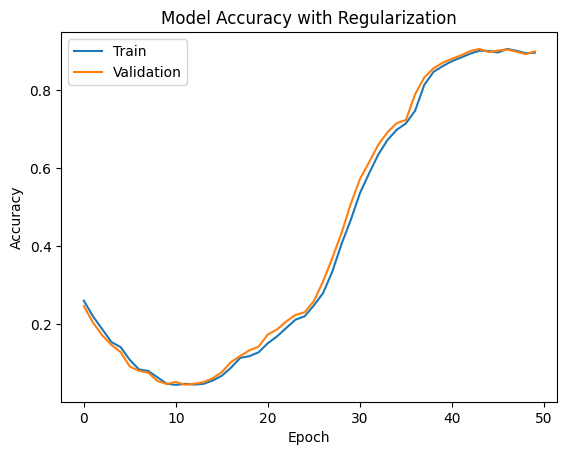

In [ ]:
# Plot accuracy with regularization
plt.plot(history_reg.history['accuracy'])
plt.plot(history_reg.history['val_accuracy'])
plt.title('Model Accuracy with Regularization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


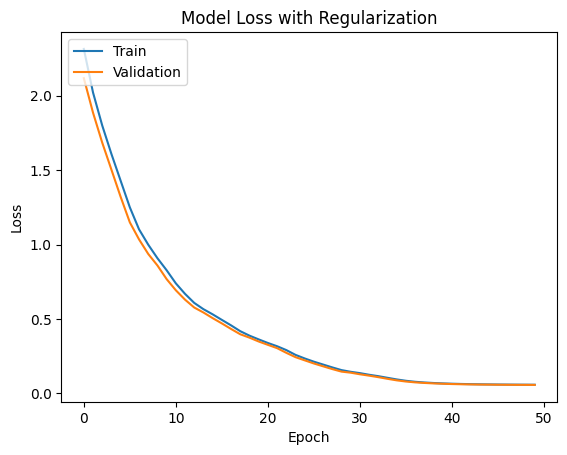

In [ ]:
# Plot loss with regularization
plt.plot(history_reg.history['loss'])
plt.plot(history_reg.history['val_loss'])
plt.title('Model Loss with Regularization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

4. For the chosen dataset, build a CNN model with at least 80%accuracy.

In [7]:
#  importing the ncecessary libraries

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import np_utils
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

In [8]:
#  Read the CIFAR 10 datasets from keras

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
#  check the number of records
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
# number of unique classes
print(np.unique(train_labels))
print(np.unique(test_labels))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [9]:
# create a list of all class labels

class_names = ['airplane','automobile','bird','cat','deer','dog','frog',
                'horse','ship','truck']


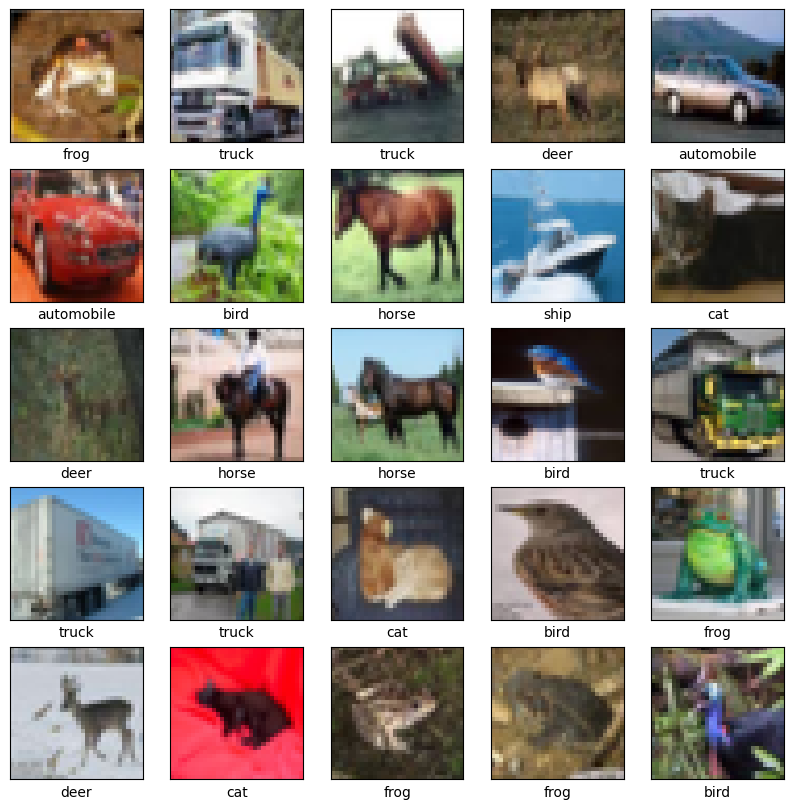

In [ ]:
# visualize the sample images from the trainning images

plt.figure(figsize= [10,10])

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])

plt.show()

In [ ]:
train_images[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [10]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

In [ ]:
train_images[0]

array([[[ 59.,  62.,  63.],
        [ 43.,  46.,  45.],
        [ 50.,  48.,  43.],
        ...,
        [158., 132., 108.],
        [152., 125., 102.],
        [148., 124., 103.]],

       [[ 16.,  20.,  20.],
        [  0.,   0.,   0.],
        [ 18.,   8.,   0.],
        ...,
        [123.,  88.,  55.],
        [119.,  83.,  50.],
        [122.,  87.,  57.]],

       [[ 25.,  24.,  21.],
        [ 16.,   7.,   0.],
        [ 49.,  27.,   8.],
        ...,
        [118.,  84.,  50.],
        [120.,  84.,  50.],
        [109.,  73.,  42.]],

       ...,

       [[208., 170.,  96.],
        [201., 153.,  34.],
        [198., 161.,  26.],
        ...,
        [160., 133.,  70.],
        [ 56.,  31.,   7.],
        [ 53.,  34.,  20.]],

       [[180., 139.,  96.],
        [173., 123.,  42.],
        [186., 144.,  30.],
        ...,
        [184., 148.,  94.],
        [ 97.,  62.,  34.],
        [ 83.,  53.,  34.]],

       [[177., 144., 116.],
        [168., 129.,  94.],
        [179., 1

In [11]:
# normalization
train_images = train_images/255
test_images = test_images/255

In [12]:
# one hot encoding for the target classes
num_classes = 10

train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [ ]:
train_labels[4]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
#  build the CNN model

model = Sequential()
model.add(layers.Conv2D( filters = 32,kernel_size = (3,3) ,strides=(1, 1),padding="same",
                         data_format=None, dilation_rate=(1, 1), groups=1, activation='relu',
                         use_bias=True, kernel_initializer="glorot_uniform",bias_initializer="zeros",
                         kernel_regularizer=None,bias_regularizer=None, activity_regularizer=None,
                         kernel_constraint=None, bias_constraint=None,input_shape = (32,32,3)))

model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters = 32,kernel_size = (3,3) ,strides=(1, 1),padding="same",
                 data_format=None, dilation_rate=(1, 1), groups=1, activation='relu',
                 use_bias=True, kernel_initializer="glorot_uniform",bias_initializer="zeros",
                 kernel_regularizer=None,bias_regularizer=None, activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None))

model.add(layers.BatchNormalization())

model.add(layers.MaxPool2D(pool_size= (2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters = 64,kernel_size = (3,3) ,strides=(1, 1),padding="same",
                 data_format=None, dilation_rate=(1, 1), groups=1, activation='relu',
                 use_bias=True, kernel_initializer="glorot_uniform",bias_initializer="zeros",
                 kernel_regularizer=None,bias_regularizer=None, activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None))

model.add(layers.BatchNormalization())

model.add(layers.MaxPool2D(pool_size= (2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(units = 128 ,activation='relu', use_bias=True, kernel_initializer="glorot_uniform",
                       bias_initializer="zeros", kernel_regularizer=None, bias_regularizer=None,
                       activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units = num_classes ,activation='softmax', use_bias=True, kernel_initializer="glorot_uniform",
                       bias_initializer="zeros", kernel_regularizer=None, bias_regularizer=None,
                       activity_regularizer=None, kernel_constraint=None, bias_constraint=None))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [ ]:
model.compile(optimizer='adam', loss= keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, batch_size= 64, epochs= 100, validation_data= (test_images, test_labels))

Epoch 1/100
782/782 [==============================] - 24s 11ms/step - loss: 1.5210 - accuracy: 0.4766 - val_loss: 1.4264 - val_accuracy: 0.5041
Epoch 2/100
782/782 [==============================] - 7s 9ms/step - loss: 1.0898 - accuracy: 0.6137 - val_loss: 1.0679 - val_accuracy: 0.6215
Epoch 3/100
782/782 [==============================] - 8s 10ms/step - loss: 0.9873 - accuracy: 0.6531 - val_loss: 1.1696 - val_accuracy: 0.6317
Epoch 4/100
782/782 [==============================] - 8s 10ms/step - loss: 0.9122 - accuracy: 0.6820 - val_loss: 0.8159 - val_accuracy: 0.7196
Epoch 5/100
782/782 [==============================] - 7s 10ms/step - loss: 0.8527 - accuracy: 0.7016 - val_loss: 0.9211 - val_accuracy: 0.6761
Epoch 6/100
782/782 [==============================] - 8s 10ms/step - loss: 0.8210 - accuracy: 0.7134 - val_loss: 0.9418 - val_accuracy: 0.6881
Epoch 7/100
782/782 [==============================] - 8s 10ms/step - loss: 0.7719 - accuracy: 0.7308 - val_loss: 0.7884 - val_accuracy:

Text(0.5, 1.0, 'Loss Curves')

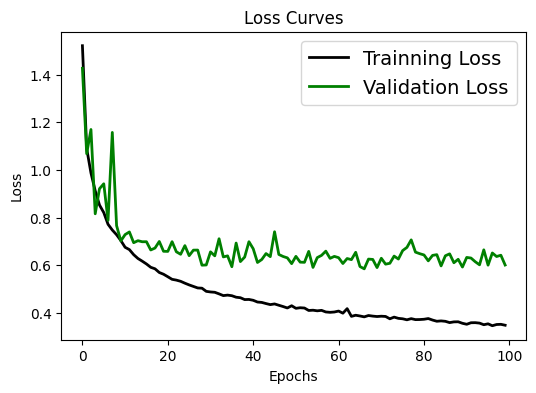

In [ ]:
# loss curve

plt.figure(figsize= [6,4])
plt.plot(history.history['loss'], 'black', linewidth = 2.0)
plt.plot(history.history['val_loss'], 'green', linewidth = 2.0)
plt.legend(['Trainning Loss', 'Validation Loss'], fontsize = 14)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.title('Loss Curves', fontsize = 12)

Text(0.5, 1.0, 'Accuracy Curves')

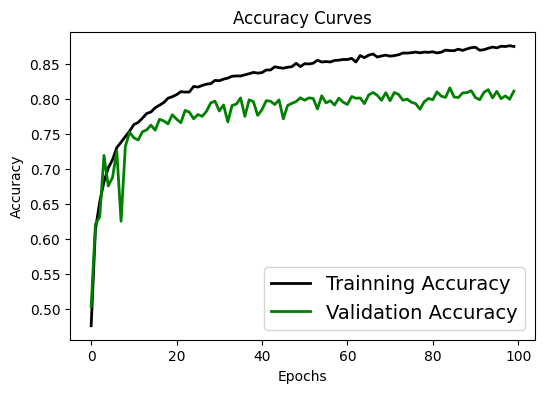

In [ ]:
# Accuracy curve

plt.figure(figsize= [6,4])
plt.plot(history.history['accuracy'], 'black', linewidth = 2.0)
plt.plot(history.history['val_accuracy'], 'green', linewidth = 2.0)
plt.legend(['Trainning Accuracy', 'Validation Accuracy'], fontsize = 14)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.title('Accuracy Curves', fontsize = 12)

5. Now include 5 data augmentation techniques appropriate to your dataset and build CNN on augmented images.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    rotation_range=60,  # randomly rotate images in the range (60, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode = "reflect"
    )
datagen.fit(train_images)

In [ ]:
epoch=50
batch_size=64

In [ ]:
history = model.fit(datagen.flow(train_images,train_labels,batch_size=batch_size),
                              epochs= epoch,validation_data=(test_images,test_labels),
                              steps_per_epoch=train_images.shape[0] // batch_size
                              )

Epoch 1/50
781/781 [==============================] - 33s 41ms/step - loss: 1.4260 - accuracy: 0.5441 - val_loss: 0.7763 - val_accuracy: 0.7440
Epoch 2/50
781/781 [==============================] - 35s 45ms/step - loss: 1.2139 - accuracy: 0.5736 - val_loss: 0.8124 - val_accuracy: 0.7210
Epoch 3/50
781/781 [==============================] - 33s 42ms/step - loss: 1.1545 - accuracy: 0.5951 - val_loss: 0.8232 - val_accuracy: 0.7096
Epoch 4/50
781/781 [==============================] - 32s 41ms/step - loss: 1.1303 - accuracy: 0.6058 - val_loss: 0.7996 - val_accuracy: 0.7202
Epoch 5/50
781/781 [==============================] - 33s 42ms/step - loss: 1.1102 - accuracy: 0.6083 - val_loss: 0.8970 - val_accuracy: 0.6837
Epoch 6/50
781/781 [==============================] - 32s 42ms/step - loss: 1.0984 - accuracy: 0.6169 - val_loss: 0.8568 - val_accuracy: 0.7110
Epoch 7/50
781/781 [==============================] - 33s 42ms/step - loss: 1.0782 - accuracy: 0.6223 - val_loss: 0.8361 - val_accuracy:

Text(0.5, 1.0, 'Loss Curves')

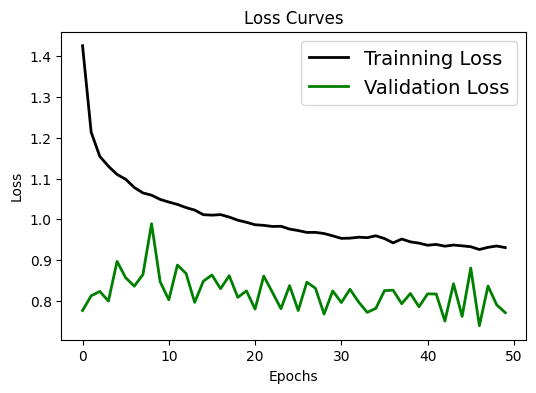

In [ ]:
# loss curve

plt.figure(figsize= [6,4])
plt.plot(history.history['loss'], 'black', linewidth = 2.0)
plt.plot(history.history['val_loss'], 'green', linewidth = 2.0)
plt.legend(['Trainning Loss', 'Validation Loss'], fontsize = 14)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.title('Loss Curves', fontsize = 12)

Text(0.5, 1.0, 'Accuracy Curves')

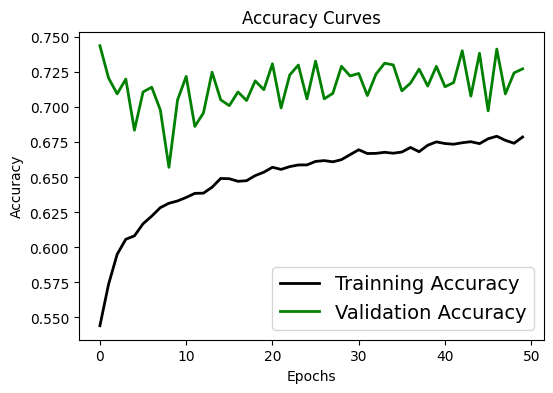

In [ ]:
# Accuracy curve

plt.figure(figsize= [6,4])
plt.plot(history.history['accuracy'], 'black', linewidth = 2.0)
plt.plot(history.history['val_accuracy'], 'green', linewidth = 2.0)
plt.legend(['Trainning Accuracy', 'Validation Accuracy'], fontsize = 14)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.title('Accuracy Curves', fontsize = 12)

6. Compare the performance of above two models

By comparing the CNN and CNN models on augmented images.(CNN 100 Epochs ,augemented CNN 50 Epochs no to be compared due to time durations I have used 50 epochs) while at 50 epoch Normal CNN model seems to be perform better

7. Choose a pre-trained model and implement from scratch on the chosen dataset

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
import matplotlib.pyplot as plt
seed = 10

In [16]:
mobilenet_v3 = MobileNetV3Small(
    include_top=False,
    weights='imagenet',
    input_shape=(32, 32, 3),
    pooling="max",
    include_preprocessing=True
)
mobilenet_v3.trainable = False
mobilenet_v3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 16, 16, 16)   432         ['rescaling_1[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 16, 16, 16)  64          ['Conv[0][0]']                   
 tion)                                                                             

In [17]:
model = Sequential()

model.add(mobilenet_v3)
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 576)              939120    
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5770      
                                                                 
Total params: 944,890
Trainable params: 5,770
Non-trainable params: 939,120
_________________________________________________________________


In [19]:
model_history = model.fit(train_images,train_labels, validation_data=(test_images, test_labels), batch_size=32, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 28s 11ms/step - loss: 2.2293 - accuracy: 0.1640 - val_loss: 2.1777 - val_accuracy: 0.1831
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 2.1418 - accuracy: 0.2165 - val_loss: 2.1349 - val_accuracy: 0.2570
Epoch 3/10
1563/1563 [==============================] - 18s 11ms/step - loss: 2.0973 - accuracy: 0.2416 - val_loss: 2.0967 - val_accuracy: 0.1960
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 2.0621 - accuracy: 0.2557 - val_loss: 2.0604 - val_accuracy: 0.2510
Epoch 5/10
1563/1563 [==============================] - 14s 9ms/step - loss: 2.0346 - accuracy: 0.2676 - val_loss: 2.0360 - val_accuracy: 0.2570
Epoch 6/10
1563/1563 [==============================] - 16s 10ms/step - loss: 2.0114 - accuracy: 0.2763 - val_loss: 2.0028 - val_accuracy: 0.2887
Epoch 7/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.9944 - accuracy: 0.2837 - val_loss: 1.9909 - va

Text(0.5, 1.0, 'Loss Curves')

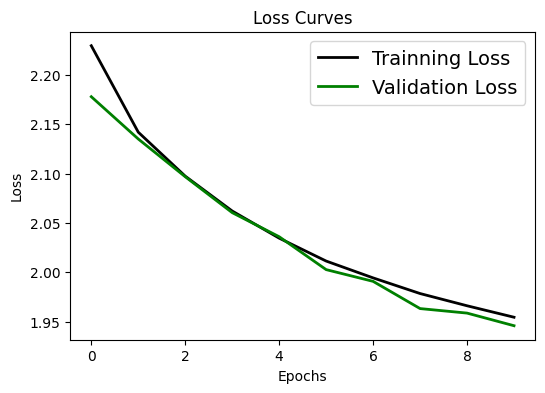

In [20]:
# loss curve
plt.figure(figsize= [6,4])
plt.plot(model_history.history['loss'], 'black', linewidth = 2.0)
plt.plot(model_history.history['val_loss'], 'green', linewidth = 2.0)
plt.legend(['Trainning Loss', 'Validation Loss'], fontsize = 14)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.title('Loss Curves', fontsize = 12)

Text(0.5, 1.0, 'Accuracy Curves')

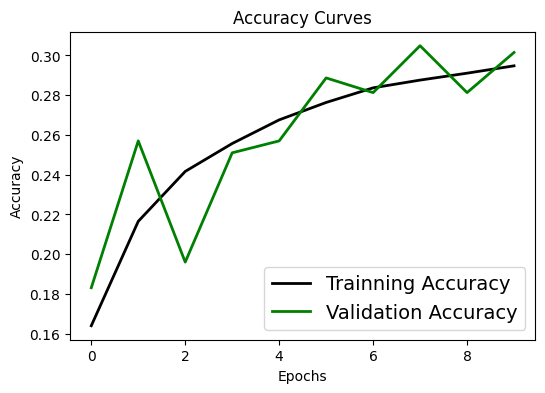

In [21]:
# Accuracy curve
plt.figure(figsize= [6,4])
plt.plot(model_history.history['accuracy'], 'black', linewidth = 2.0)
plt.plot(model_history.history['val_accuracy'], 'green', linewidth = 2.0)
plt.legend(['Trainning Accuracy', 'Validation Accuracy'], fontsize = 14)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.title('Accuracy Curves', fontsize = 12)

8. Choose a pre-trained model and implement as transfer learning on the chosen dataset

In [24]:
model = Sequential()

model.add(mobilenet_v3)
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 576)              939120    
 l)                                                              
                                                                 
 flatten_3 (Flatten)         (None, 576)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                36928     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 10)                330       
                                                                 
Total params: 978,458
Trainable params: 39,338
Non-trainable params: 939,120
___________________________________________

In [26]:
model_history = model.fit(train_images,train_labels, validation_data=(test_images, test_labels), batch_size=32, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 18s 11ms/step - loss: 1.9186 - accuracy: 0.2700 - val_loss: 1.9157 - val_accuracy: 0.2766
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.9127 - accuracy: 0.2729 - val_loss: 1.9721 - val_accuracy: 0.2511
Epoch 3/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.9111 - accuracy: 0.2763 - val_loss: 1.8981 - val_accuracy: 0.2851
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.9033 - accuracy: 0.2810 - val_loss: 1.9254 - val_accuracy: 0.2731
Epoch 5/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.8988 - accuracy: 0.2821 - val_loss: 1.8914 - val_accuracy: 0.2868
Epoch 6/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.8978 - accuracy: 0.2834 - val_loss: 1.9252 - val_accuracy: 0.2693
Epoch 7/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.8920 - accuracy: 0.2863 - val_loss: 1.8949 - va

Text(0.5, 1.0, 'Loss Curves')

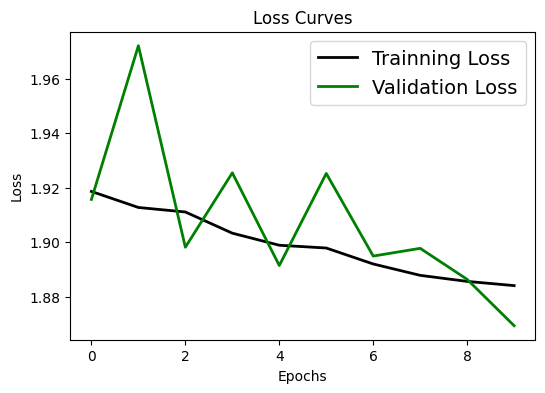

In [27]:
# loss curve
plt.figure(figsize= [6,4])
plt.plot(model_history.history['loss'], 'black', linewidth = 2.0)
plt.plot(model_history.history['val_loss'], 'green', linewidth = 2.0)
plt.legend(['Trainning Loss', 'Validation Loss'], fontsize = 14)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.title('Loss Curves', fontsize = 12)

Text(0.5, 1.0, 'Accuracy Curves')

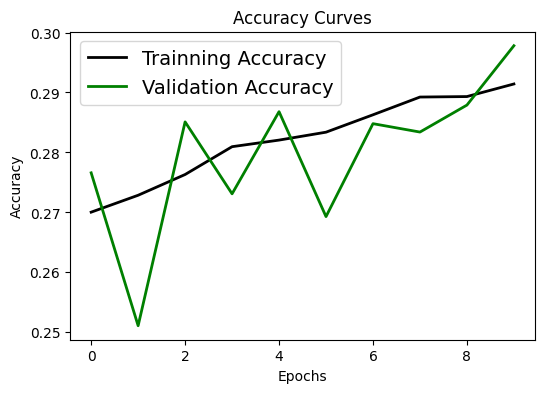

In [28]:
# Accuracy curve
plt.figure(figsize= [6,4])
plt.plot(model_history.history['accuracy'], 'black', linewidth = 2.0)
plt.plot(model_history.history['val_accuracy'], 'green', linewidth = 2.0)
plt.legend(['Trainning Accuracy', 'Validation Accuracy'], fontsize = 14)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.title('Accuracy Curves', fontsize = 12)